# Observed Air Quality (PurpleAir)

This notebook retrieves readings from PurpleAir Sensors in Minneapolis and cleans the entries and saves the results as a csv file.

Documentation is available here: https://api.purpleair.com.
You can read this article for help getting started: https://community.purpleair.com/t/making-api-calls-with-the-purpleair-api/180.

The data from individual sensors will update no less than every 30 seconds. As a courtesy, we ask that you limit the number of requests to no more than once every 1 to 10 minutes, assuming you are only using the API to obtain data from sensors. If retrieving data from multiple sensors at once, please send a single request rather than individual requests in succession.

The PurpleAir historical API is released as of July 18, 2022. For more information, view this post: https://community.purpleair.com/t/new-version-of-the-purpleair-api-on-july-18th/1251.

Please let us know if you have any questions or concerns, and have a great day!

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import requests 
import datetime as dt # Converting unix time


# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
import contextily # Base Map Visualization

import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

In [2]:
# Extent of study (8km from Mpls)

# Minneapolis Boundary

mpls_path = os.path.join(os.getcwd(), '..', '1_Data_IO', 'Data', 'mpls_boundary.geojson')
mpls = gpd.read_file(mpls_path)

# Get extent

mpls_buffed = mpls.geometry.buffer(8000)

# Get current data on stations within study

In [5]:
# This function will be used to collect data for multiple public PurpleAir sensors.
def getSensorsData(query='', api_read_key=''):

    # my_url is assigned the URL we are going to send our request to.
    url = 'https://api.purpleair.com/v1/sensors?' + query

    # my_headers is assigned the context of our request we want to make. In this case
    # we will pass through our API read key using the variable created above.
    my_headers = {'X-API-Key':api_read_key}

    # This line creates and sends the request and then assigns its response to the
    # variable, r.
    r = requests.get(url, headers=my_headers)

    # We then return the response we received.
    return r

In [6]:
api = input('Please enter your Purple Air api key')

Please enter your Purple Air api key 7121DCD0-1F0E-11ED-8561-42010A800005


In [7]:
bounds = nwlng, selat, selng, nwlat = mpls_buffed.to_crs('EPSG:4326').total_bounds

In [8]:
bounds_strings = [f'nwlng={nwlng}',
                  f'nwlat={nwlat}',
                  f'selng={selng}',
                  f'selat={selat}']

bounds_string = '&'.join(bounds_strings)

In [9]:
fields = ['name', 'position_rating', 'date_created', 'last_modified', 'last_seen', 'altitude',
          'location_type', 'uptime',
          'latitude', 'longitude', 'pm2.5']

fields_string = 'fields=' + '%2C'.join(fields)

In [10]:
query_string = '&'.join([fields_string, bounds_string])

In [11]:
r = getSensorsData(query_string, api)

In [13]:
# Get response into dataframe

response_dict = r.json()

col_names = response_dict['fields']
data = np.array(response_dict['data'])

df = pd.DataFrame(data, columns = col_names)

In [14]:
# Only want outside sensors

outside_sensors = df[df.location_type=='0'] # 0 = outside

In [29]:
# Check it out spatially

geom = gpd.points_from_xy(outside_sensors.longitude, outside_sensors.latitude, crs = 'EPSG:4326')

gdf = gpd.GeoDataFrame(outside_sensors, geometry = geom)

gdf['pm2.5'] = gdf['pm2.5'].astype(float)

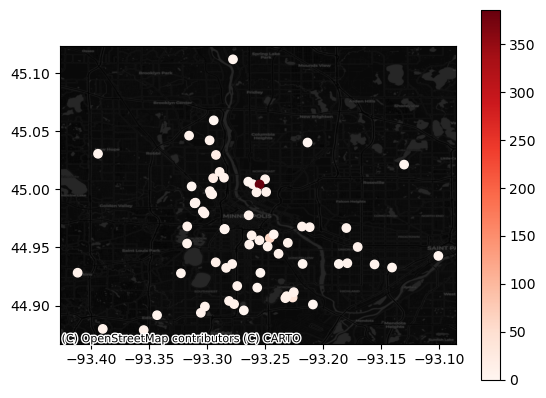

In [33]:
art = gdf.plot(column = 'pm2.5', cmap = 'Reds', legend = True)

contextily.add_basemap(ax = art,
                       crs = gdf.crs,
                      source = contextily.providers.CartoDB.DarkMatter)

In [34]:
# Perfect, now let's make sure they're up to date!

# Have we seen all of these recently?

last_seen = outside_sensors.last_seen.apply(lambda x: dt.datetime.fromtimestamp(int(x))).values

print('Last sensor was seen: ', np.sort(last_seen)[0])


Last sensor was seen:  2022-11-10T10:26:39.000000000


In [35]:
# Okay, it looks okay. Now to save this info

outside_sensors.to_csv(os.path.join('Data','sensors.csv'))

# Historical Data?

## Using API (Does Not Work)

They're restricting this API usage...

<https://community.purpleair.com/t/historical-api-endpoints-are-now-restricted/1557>

In [24]:
# Let's get their histories from the past year? 

# Start time

start_datetime = dt.datetime(2022,11,10) # November 10th, 2022
start_timestamp = int(dt.datetime.timestamp(start_datetime))

# End time

end_datetime = dt.datetime(2021,11,10) # November 10th, 2021
end_timestamp = int(dt.datetime.timestamp(end_datetime))

# Sensors

sensor_ids = outside_sensors.sensor_index.apply(lambda x: int(x))

In [25]:
# Sensor id

sensor_id = sensor_ids[0]

# Timestamp String

time_string = 'start_timestamp=' + str(start_timestamp) + '&end_timestamp=' + str(end_timestamp)

# Average string (in minutes)

avg_string = 'average=360'

# Environmental fields

env_fields = ['humidity', 'temperature', 'pressure', 'voc', 'pm2.5_alt', 'pm2.5_atm', 'pm2.5_cf_1']

env_fields_string = '%2C'.join(env_fields)

# Base URL

base_url = f'https://api.purpleair.com/v1/sensors/{sensor_id}/history/'

# Put it all together

query_url = base_url + '&'.join([time_string, avg_string, env_fields_string])

my_headers = {'X-API-Key':api}

# This line creates and sends the request and then assigns its response to the
# variable, r.
r = requests.get(query_url, headers=my_headers)

In [26]:
r.text

'{\n  "api_version" : "V1.0.11-0.0.41",\n  "time_stamp" : 1668210611,\n  "error" : "ApiDisabledError",\n  "description" : "API calls to this endpoint (get_sensor_history) have been restricted. Please try again later or contact PurpleAir for more information."\n}'

In [ ]:
# Dang, they're restricting this API usage...

# https://community.purpleair.com/t/historical-api-endpoints-are-now-restricted/1557

## Downloading using their tool (takes for ever!!!)


In [37]:
# Csv names need to be parsed

import re # String findings

filenames = os.listdir('PurpleAirCSVs')


# Get coords, if outside, and if city owned

names = []
lats = []
lons = []
is_outside = []
is_city = []
is_B = []

for filename in filenames:
    # Get name
    name = filename.split('(')[0]
    names += [name]
    # Is it a B sensor?
    if name[-2:-1] == 'B':
        is_B.append('Yes')
    else:
        is_B.append('No')
    # Coordinates & If outside
    result = re.findall('\(.*?\)', filename)
    if len(result) == 2:
        is_outside += [result[0][1:-1]]
        coords = result[1][1:-1]
    elif len(result) == 3:
        is_outside += [result[1][1:-1]]
        coords = result[2][1:-1]
    lats.append(coords.split(' ')[0])
    lons.append(coords.split(' ')[1])
    # Is part of City's project
    if 'Community Air Monitoring Project'.upper() in filename.upper():
        is_city.append('Yes')
    else:
        is_city.append('No')

# See if active in past year 2022

is_active = []

for name in names:
    filepath = os.path.join('PurpleAirCSVs', filename)
    data = pd.read_csv(filepath)
    if data.size == 0:
        is_active.append('No')
    else:
        is_active.append('Yes')

In [38]:
# Initialize geodataframe

columns = ['filename', 'name', 'is_active', 'is_outside', 'is_city', 'is_B', 'latitude', 'longitude']

sensors = pd.DataFrame(zip(filenames, names, is_active, is_outside, is_city, is_B, lats, lons), 
                                   columns = columns)

In [39]:
sensors.info()
sensors.sample(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    524 non-null    object
 1   name        524 non-null    object
 2   is_active   524 non-null    object
 3   is_outside  524 non-null    object
 4   is_city     524 non-null    object
 5   is_B        524 non-null    object
 6   latitude    524 non-null    object
 7   longitude   524 non-null    object
dtypes: object(8)
memory usage: 32.9+ KB


filename  \
180  City of Minneapolis Community Air Monitoring P...   

                                                  name is_active is_outside  \
180  City of Minneapolis Community Air Monitoring P...       Yes  undefined   

    is_city is_B   latitude   longitude  
180     Yes  Yes  44.995792  -93.295396

In [40]:
# Match with earlier sensors to get IDs?
# Maybe at some point... For Now, just work with data

In [41]:
# Example date 2022-03-21 12:00:00 UTC

def make_string_datetime(string):
    # Example date 2022-03-21 12:00:00 UTC
    ''' This function converts a string in Purple Air CSV to datetime object'''
    
    d = int(string.split('-')[2][:2])
    m = int(string.split('-')[1])
    y = int(string.split('-')[0])
    h = int(string.split(' ')[1][:2])
    
    return dt.datetime(year = y,
                       month = m,
                       day = d,
                       hour = h)
    


In [42]:
# Select only sensors with enough observations (1/2 year)
# Only use the "A" sensors
# Get the average 'PM2.5_ATM_ug/m3' reading

import datetime as dt

A_sensors = sensors[sensors['is_B'] == 'No']

A_filenames = A_sensors.filename

good_datasets = []
good_indices = []

for i, sensor in A_sensors.iterrows():
    path = os.path.join('PurpleAirCSVs', sensor.filename)
    data = pd.read_csv(path)
    
    if len(data) > 360: # At least half a year of observations?
        if 'PM2.5_ATM_ug/m3' in data.columns:
            good_datasets += [sensor.filename]
            good_indices += [i]
            
            data['datetimes'] = data.created_at.apply(lambda x: make_string_datetime(x))
            
            sensors.loc[i, 'Start_Date'] = min(data.datetimes)
            sensors.loc[i, 'End_Date'] = max(data.datetimes)
            sensors.loc[i, 'Observations'] = len(data)

In [43]:
sensors_for_interpolation = sensors.iloc[good_indices]

In [44]:
max(sensors_for_interpolation.Start_Date)

Timestamp('2022-07-14 12:00:00')

In [45]:
# So we will use this as our baseline for determining average

max_start = max(sensors_for_interpolation.Start_Date)

for i, sensor in sensors_for_interpolation.iterrows():
    
    # Load Data
    path = os.path.join('PurpleAirCSVs', sensor.filename)
    data = pd.read_csv(path)
    
    # Only use observations after max_start
    data['datetimes'] = data.created_at.apply(lambda x: make_string_datetime(x))
    select_data = data[data.datetimes >= max_start]
    sensors_for_interpolation.loc[i, 'Avg_pm2.5'] = select_data['PM2.5_ATM_ug/m3'].mean()

In [46]:
len(sensors_for_interpolation)

71

In [47]:
sensors_for_interpolation.head()

filename  \
6   Lee Circle (outside) (44.9073 -93.60277) Prima...   
14  MPCA_Blaine (outside) (45.1407 -93.222) Primar...   
44  City of Minneapolis Community Air Monitoring P...   
48  Edina MN (outside) (44.878832 -93.354406) Prim...   
49  Cityscape (outside) (44.940389 -93.351256) Pri...   

                                                 name is_active is_outside  \
6                                         Lee Circle        Yes    outside   
14                                       MPCA_Blaine        Yes    outside   
44  City of Minneapolis Community Air Monitoring P...       Yes    outside   
48                                          Edina MN        Yes    outside   
49                                         Cityscape        Yes    outside   

   is_city is_B   latitude   longitude          Start_Date  \
6       No   No    44.9073   -93.60277 2021-11-13 00:00:00   
14      No   No    45.1407     -93.222 2021-11-13 00:00:00   
44     Yes   No  44.908063  -93.231281 2022-03-21 12:00:00   
48      No   No  44.878832  -93.354406 2021-11-13 00:00:00   
49      No   No  44.940389  -93.351256 2021-11-13 00:00:00   

              End_Date  Observations  Avg_pm2.5  
6  2022-10-25 12:00:00        1112.0   0.237451  
14 2022-10-25 12:00:00        1021.0   6.903046  
44 2022-10-25 12:00:00         592.0   7.299420  
48 2022-10-25 12:00:00        1124.0   7.468068  
49 2022-10-25 12:00:00        1146.0   8.594396

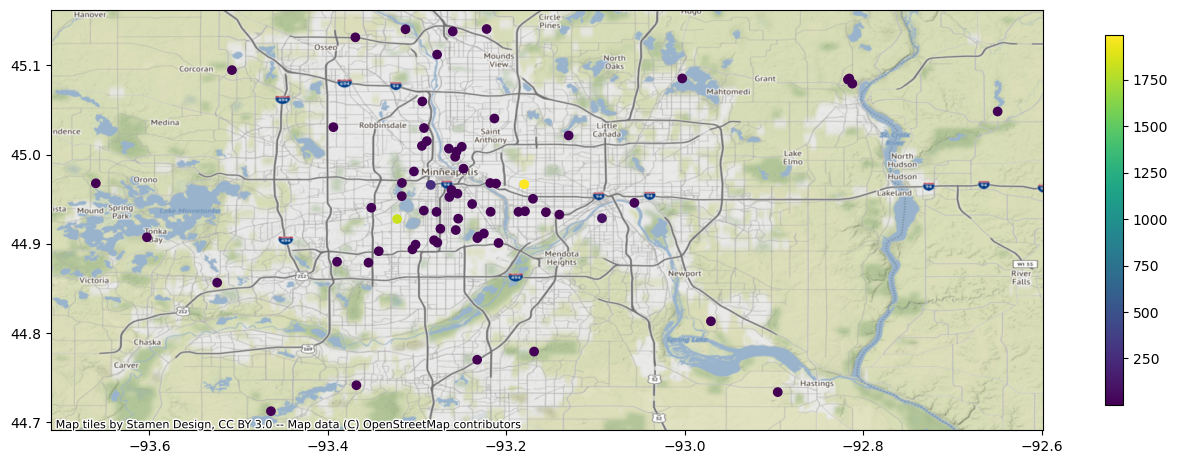

In [48]:
# Look at it spatially

geom = gpd.points_from_xy(sensors_for_interpolation.longitude, 
                          sensors_for_interpolation.latitude,
                          crs = 'EPSG:4326')

gdf = gpd.GeoDataFrame(sensors_for_interpolation, geometry = geom)

art = gdf.plot('Avg_pm2.5', legend = True, figsize = (16,16),
              legend_kwds={'shrink': 0.3})

contextily.add_basemap(ax = art,
                       crs = gdf.crs)

In [49]:
# What the? Where is the average so high??

highest_index = sensors_for_interpolation['Avg_pm2.5'].argmax()

sensor = sensors_for_interpolation.iloc[highest_index]

sensor

filename        Hamline Midway (outside) (44.966744 -93.179843...
name                                              Hamline Midway 
is_active                                                     Yes
is_outside                                                outside
is_city                                                        No
is_B                                                           No
latitude                                                44.966744
longitude                                              -93.179843
Start_Date                                    2021-11-13 00:00:00
End_Date                                      2022-10-25 12:00:00
Observations                                               1146.0
Avg_pm2.5                                             1989.410628
geometry                             POINT (-93.179843 44.966744)
Name: 110, dtype: object

In [50]:
# Load that data
path = os.path.join('PurpleAirCSVs', sensor.filename)

data = pd.read_csv(path)

data['datetimes'] = data.created_at.apply(lambda x: make_string_datetime(x))

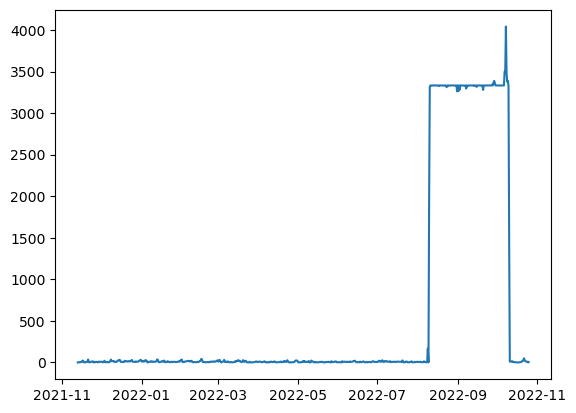

In [51]:
plt.plot(data.datetimes,data['PM2.5_ATM_ug/m3'])

In [52]:
# Whoa! I wonder what that's all about?
# Probably can't use this one...

In [53]:
good_indices = list(sensors_for_interpolation.index)
good_indices.pop(highest_index)

sensors_for_interpolation = sensors_for_interpolation.loc[good_indices]

In [54]:
# Let's try that again

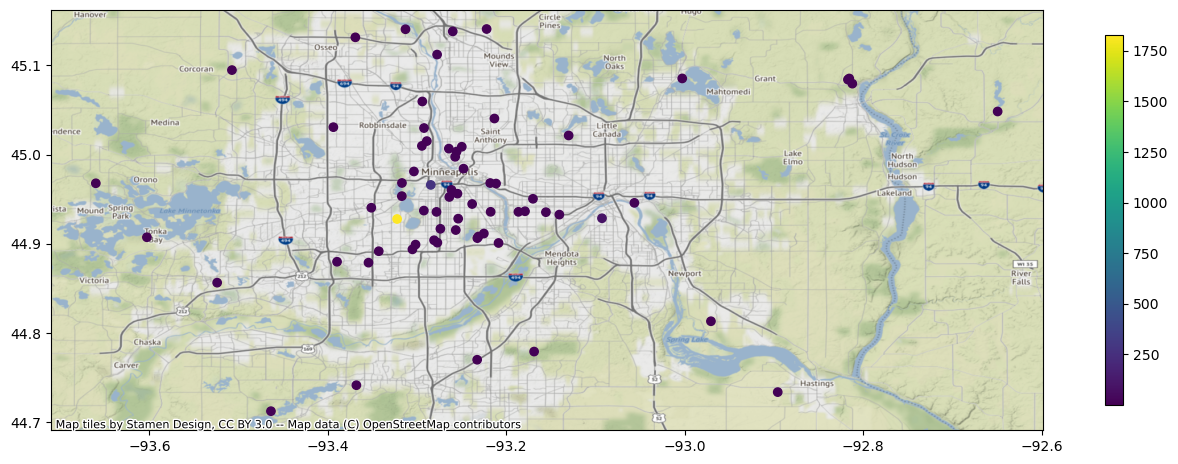

In [55]:
# Look at it spatially

geom = gpd.points_from_xy(sensors_for_interpolation.longitude, 
                          sensors_for_interpolation.latitude,
                          crs = 'EPSG:4326')

gdf = gpd.GeoDataFrame(sensors_for_interpolation, geometry = geom)

art = gdf.plot('Avg_pm2.5', legend = True, figsize = (16,16),
              legend_kwds={'shrink': 0.3})

contextily.add_basemap(ax = art,
                       crs = gdf.crs)

In [56]:
# What the? Where is the average so high??

highest_index = sensors_for_interpolation['Avg_pm2.5'].argmax()

sensor = sensors_for_interpolation.iloc[highest_index]

sensor

filename        Linden Hills (outside) (44.927761 -93.322353) ...
name                                                Linden Hills 
is_active                                                     Yes
is_outside                                                outside
is_city                                                        No
is_B                                                           No
latitude                                                44.927761
longitude                                              -93.322353
Start_Date                                    2021-11-13 00:00:00
End_Date                                      2022-10-25 12:00:00
Observations                                               1146.0
Avg_pm2.5                                             1827.039903
geometry                             POINT (-93.322353 44.927761)
Name: 492, dtype: object

In [57]:
# Load that data
path = os.path.join('PurpleAirCSVs', sensor.filename)

data = pd.read_csv(path)

data['datetimes'] = data.created_at.apply(lambda x: make_string_datetime(x))

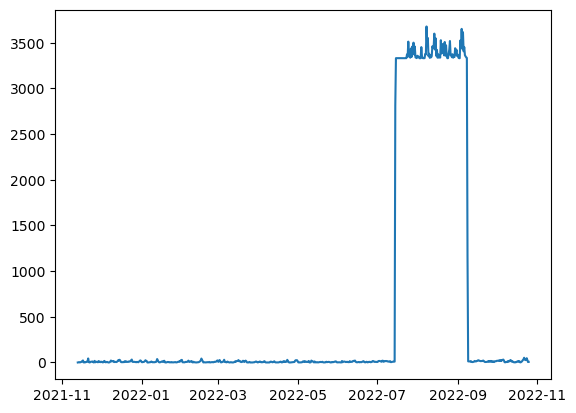

In [58]:
plt.plot(data.datetimes,data['PM2.5_ATM_ug/m3'])

In [59]:
# Whoa! I wonder what that's all about?
# Probably can't use this one either...

In [60]:
good_indices = list(sensors_for_interpolation.index)
good_indices.pop(highest_index)

sensors_for_interpolation = sensors_for_interpolation.loc[good_indices]

In [61]:
# Let's try that again

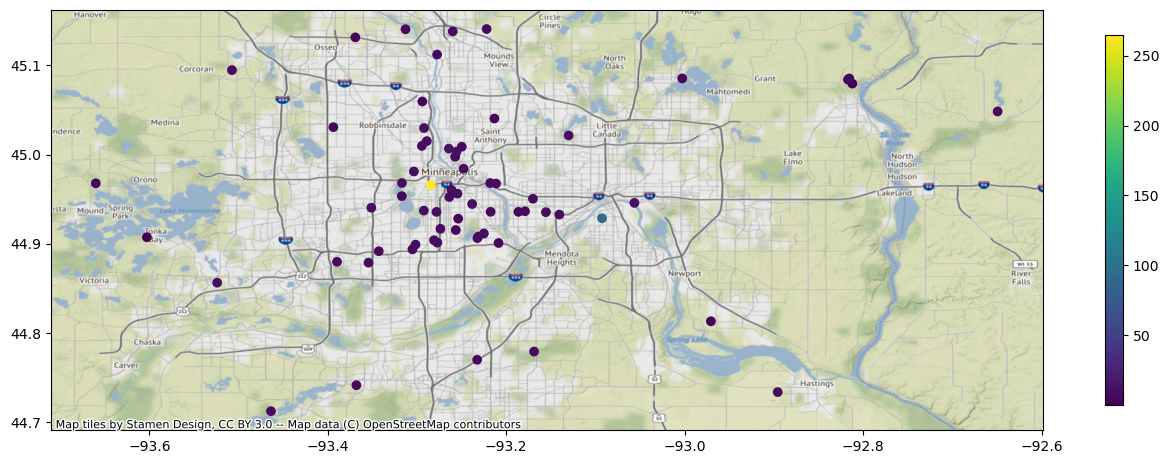

In [62]:
# Look at it spatially

geom = gpd.points_from_xy(sensors_for_interpolation.longitude, 
                          sensors_for_interpolation.latitude,
                          crs = 'EPSG:4326')

gdf = gpd.GeoDataFrame(sensors_for_interpolation, geometry = geom)

art = gdf.plot('Avg_pm2.5', legend = True, figsize = (16,16),
              legend_kwds={'shrink': 0.3})

contextily.add_basemap(ax = art,
                       crs = gdf.crs)

In [63]:
# What the? Where is the average so high??

highest_index = sensors_for_interpolation['Avg_pm2.5'].argmax()

sensor = sensors_for_interpolation.iloc[highest_index]

sensor

filename        Mpls-Loring Park (outside) (44.965964 -93.2846...
name                                            Mpls-Loring Park 
is_active                                                     Yes
is_outside                                                outside
is_city                                                        No
is_B                                                           No
latitude                                                44.965964
longitude                                              -93.284616
Start_Date                                    2021-11-13 00:00:00
End_Date                                      2022-11-08 12:00:00
Observations                                               1083.0
Avg_pm2.5                                              264.533675
geometry                             POINT (-93.284616 44.965964)
Name: 203, dtype: object

In [64]:
# Load that data
path = os.path.join('PurpleAirCSVs', sensor.filename)

data = pd.read_csv(path)

data['datetimes'] = data.created_at.apply(lambda x: make_string_datetime(x))

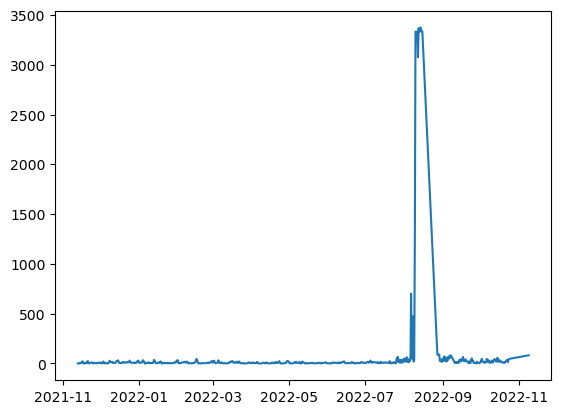

In [65]:
plt.plot(data.datetimes,data['PM2.5_ATM_ug/m3'])

In [66]:
# Whoa! I wonder what that's all about?
# Probably can't use this one either...

In [67]:
good_indices = list(sensors_for_interpolation.index)
good_indices.pop(highest_index)

sensors_for_interpolation = sensors_for_interpolation.loc[good_indices]

In [68]:
# Let's try that again

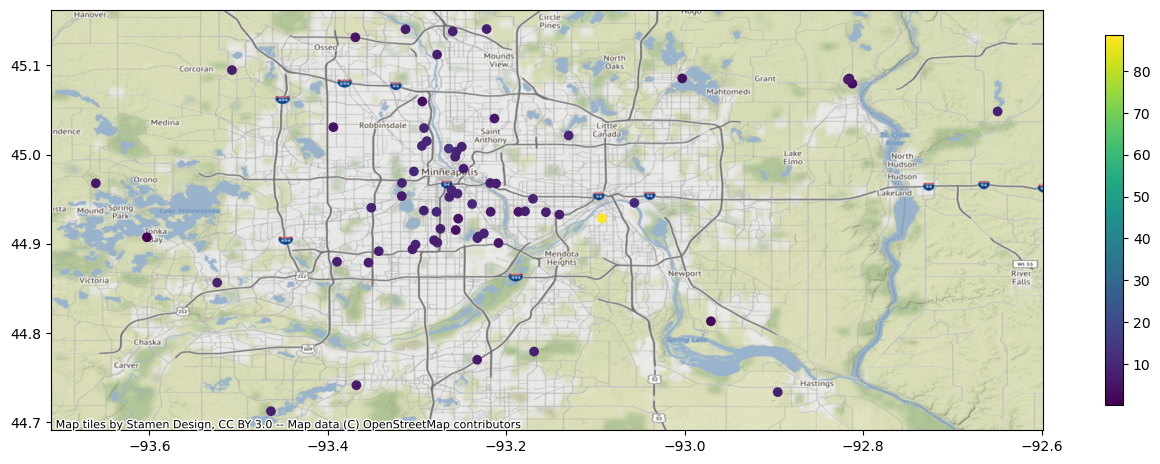

In [69]:
# Look at it spatially

geom = gpd.points_from_xy(sensors_for_interpolation.longitude, 
                          sensors_for_interpolation.latitude,
                          crs = 'EPSG:4326')

gdf = gpd.GeoDataFrame(sensors_for_interpolation, geometry = geom)

art = gdf.plot('Avg_pm2.5', legend = True, figsize = (16,16),
              legend_kwds={'shrink': 0.3})

contextily.add_basemap(ax = art,
                       crs = gdf.crs)

In [70]:
# What the? Where is the average so high??

highest_index = sensors_for_interpolation['Avg_pm2.5'].argmax()

sensor = sensors_for_interpolation.iloc[highest_index]

sensor

filename        Saint Paul West Side (outside) (44.928602 -93....
name                                        Saint Paul West Side 
is_active                                                     Yes
is_outside                                                outside
is_city                                                        No
is_B                                                           No
latitude                                                44.928602
longitude                                               -93.09272
Start_Date                                    2022-07-14 12:00:00
End_Date                                      2022-10-25 12:00:00
Observations                                                396.0
Avg_pm2.5                                               88.552071
geometry                              POINT (-93.09272 44.928602)
Name: 91, dtype: object

In [71]:
# Load that data
path = os.path.join('PurpleAirCSVs', sensor.filename)

data = pd.read_csv(path)

data['datetimes'] = data.created_at.apply(lambda x: make_string_datetime(x))

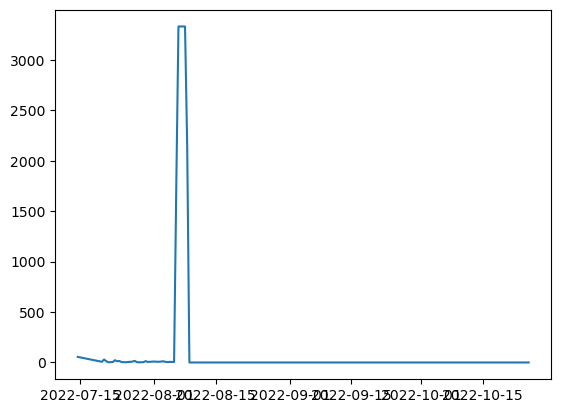

In [72]:
plt.plot(data.datetimes,data['PM2.5_ATM_ug/m3'])

In [73]:
# Whoa! I wonder what that's all about?
# Probably can't use this one...

In [74]:
good_indices = list(sensors_for_interpolation.index)
good_indices.pop(highest_index)

sensors_for_interpolation = sensors_for_interpolation.loc[good_indices]

In [75]:
# Let's try that again

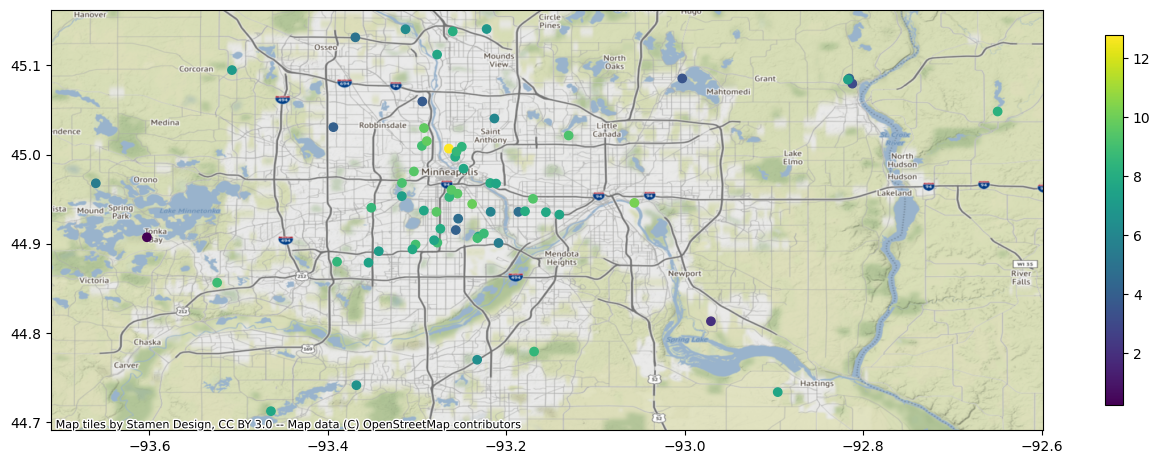

In [76]:
# Look at it spatially

geom = gpd.points_from_xy(sensors_for_interpolation.longitude, 
                          sensors_for_interpolation.latitude,
                          crs = 'EPSG:4326')

gdf = gpd.GeoDataFrame(sensors_for_interpolation, geometry = geom)

art = gdf.plot('Avg_pm2.5', legend = True, figsize = (16,16),
              legend_kwds={'shrink': 0.3})

contextily.add_basemap(ax = art,
                       crs = gdf.crs)

In [77]:
# That's more like it!

# Save it

utm_gdf = gdf.to_crs('EPSG:26915')

utm_gdf['EASTING'] = utm_gdf.geometry.x
utm_gdf['NORTHING'] = utm_gdf.geometry.y

path = os.path.join('Data', 'pm25_avg.csv')
utm_gdf.reset_index().to_csv(path, index = False)